In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 109247045.83it/s]


Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 74225302.59it/s]


Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29439848.27it/s]


Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1230733.82it/s]


Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:18,  6.29it/s]                         


Epoch 1 of 100
Generator loss: 1.30737078, Discriminator loss: 0.94398731


118it [00:15,  7.75it/s]                         


Epoch 2 of 100
Generator loss: 2.19187999, Discriminator loss: 1.20948362


118it [00:14,  7.92it/s]                         


Epoch 3 of 100
Generator loss: 3.18754721, Discriminator loss: 0.88682455


118it [00:17,  6.74it/s]                         


Epoch 4 of 100
Generator loss: 2.73753405, Discriminator loss: 0.85594660


118it [00:15,  7.85it/s]                         


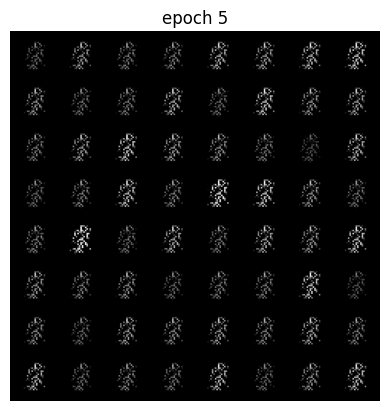

Epoch 5 of 100
Generator loss: 1.18548560, Discriminator loss: 1.24689448


118it [00:15,  7.76it/s]                         


Epoch 6 of 100
Generator loss: 2.98280978, Discriminator loss: 0.62314516


118it [00:15,  7.75it/s]                         


Epoch 7 of 100
Generator loss: 2.54016709, Discriminator loss: 0.98114043


118it [00:15,  7.61it/s]                         


Epoch 8 of 100
Generator loss: 1.44011176, Discriminator loss: 1.15712965


118it [00:15,  7.69it/s]                         


Epoch 9 of 100
Generator loss: 2.51031637, Discriminator loss: 0.81087077


118it [00:15,  7.67it/s]                         


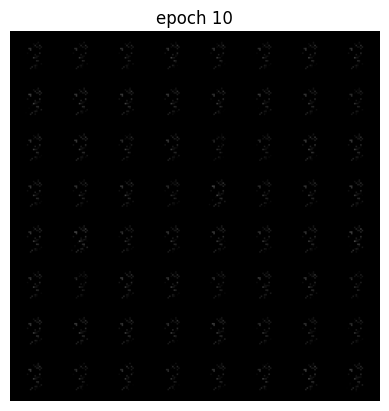

Epoch 10 of 100
Generator loss: 2.12484384, Discriminator loss: 1.13075614


118it [00:15,  7.71it/s]                         


Epoch 11 of 100
Generator loss: 1.92806053, Discriminator loss: 1.11856019


118it [00:15,  7.74it/s]                         


Epoch 12 of 100
Generator loss: 1.85342944, Discriminator loss: 1.29612994


118it [00:15,  7.81it/s]                         


Epoch 13 of 100
Generator loss: 1.58532512, Discriminator loss: 0.98217744


118it [00:14,  7.90it/s]                         


Epoch 14 of 100
Generator loss: 1.60084724, Discriminator loss: 1.19369006


118it [00:15,  7.84it/s]                         


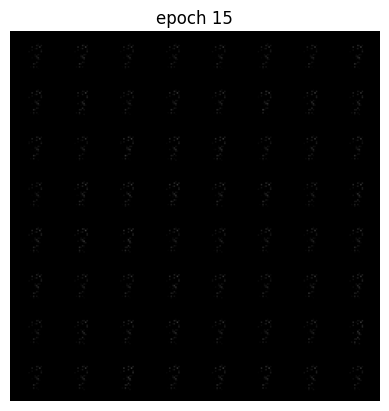

Epoch 15 of 100
Generator loss: 2.01528001, Discriminator loss: 1.03151667


118it [00:15,  7.83it/s]                         


Epoch 16 of 100
Generator loss: 0.75700200, Discriminator loss: 1.34021175


118it [00:15,  7.82it/s]                         


Epoch 17 of 100
Generator loss: 1.45416427, Discriminator loss: 0.91309565


118it [00:15,  7.80it/s]                         


Epoch 18 of 100
Generator loss: 1.86985254, Discriminator loss: 0.86692500


118it [00:15,  7.60it/s]                         


Epoch 19 of 100
Generator loss: 2.73340917, Discriminator loss: 0.89197952


118it [00:15,  7.51it/s]                         


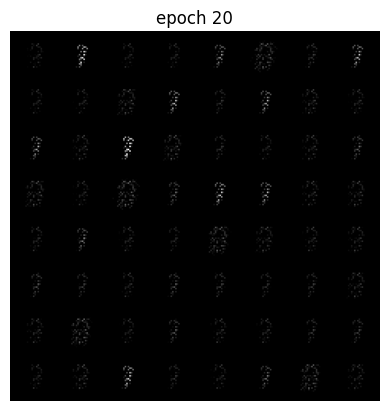

Epoch 20 of 100
Generator loss: 2.22595072, Discriminator loss: 0.89490533


118it [00:15,  7.65it/s]                         


Epoch 21 of 100
Generator loss: 1.99848771, Discriminator loss: 0.89264959


118it [00:15,  7.67it/s]                         


Epoch 22 of 100
Generator loss: 2.08594441, Discriminator loss: 0.57397747


118it [00:15,  7.74it/s]                         


Epoch 23 of 100
Generator loss: 2.40987706, Discriminator loss: 0.55504030


118it [00:15,  7.63it/s]                         


Epoch 24 of 100
Generator loss: 2.68614578, Discriminator loss: 0.49783173


118it [00:15,  7.78it/s]                         


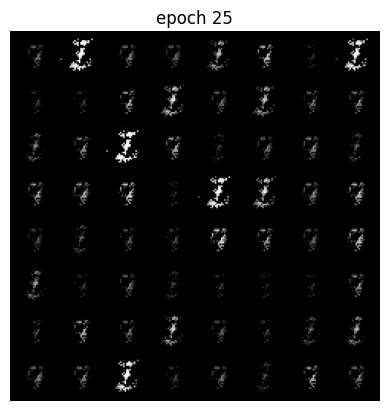

Epoch 25 of 100
Generator loss: 2.33266592, Discriminator loss: 0.66476405


118it [00:15,  7.71it/s]                         


Epoch 26 of 100
Generator loss: 2.44908547, Discriminator loss: 0.63736254


118it [00:15,  7.81it/s]                         


Epoch 27 of 100
Generator loss: 2.44004107, Discriminator loss: 0.59689075


118it [00:15,  7.61it/s]                         


Epoch 28 of 100
Generator loss: 2.49736691, Discriminator loss: 0.63682038


118it [00:15,  7.59it/s]                         


Epoch 29 of 100
Generator loss: 2.58826733, Discriminator loss: 0.49646997


118it [00:15,  7.55it/s]                         


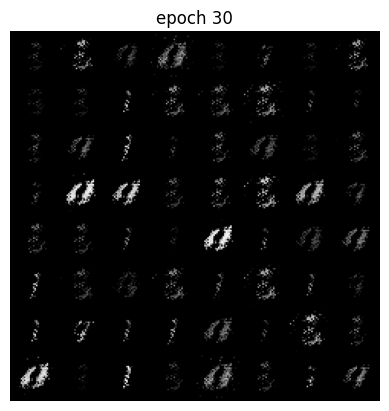

Epoch 30 of 100
Generator loss: 2.62209558, Discriminator loss: 0.58669722


118it [00:16,  7.10it/s]                         


Epoch 31 of 100
Generator loss: 2.45223355, Discriminator loss: 0.58511096


118it [00:15,  7.63it/s]                         


Epoch 32 of 100
Generator loss: 2.69361877, Discriminator loss: 0.67587608


118it [00:15,  7.73it/s]                         


Epoch 33 of 100
Generator loss: 2.36440730, Discriminator loss: 0.56194133


118it [00:15,  7.77it/s]                         


Epoch 34 of 100
Generator loss: 2.49574471, Discriminator loss: 0.51327294


118it [00:15,  7.74it/s]                         


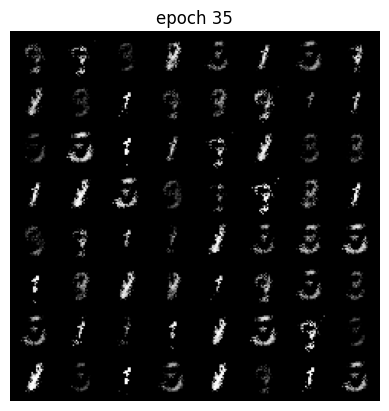

Epoch 35 of 100
Generator loss: 2.48863816, Discriminator loss: 0.56297225


118it [00:15,  7.69it/s]                         


Epoch 36 of 100
Generator loss: 2.34246421, Discriminator loss: 0.62703311


118it [00:15,  7.69it/s]                         


Epoch 37 of 100
Generator loss: 2.29149365, Discriminator loss: 0.63653904


118it [00:15,  7.47it/s]                         


Epoch 38 of 100
Generator loss: 2.73162627, Discriminator loss: 0.46869418


118it [00:15,  7.48it/s]                         


Epoch 39 of 100
Generator loss: 2.13411188, Discriminator loss: 0.74656016


118it [00:15,  7.59it/s]                         


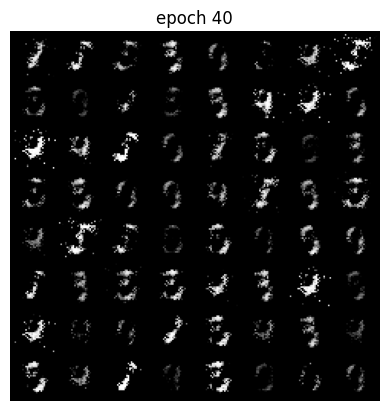

Epoch 40 of 100
Generator loss: 1.82555068, Discriminator loss: 0.77254933


118it [00:15,  7.77it/s]                         


Epoch 41 of 100
Generator loss: 1.95930207, Discriminator loss: 0.77927941


118it [00:15,  7.67it/s]                         


Epoch 42 of 100
Generator loss: 1.85133147, Discriminator loss: 0.75856119


118it [00:15,  7.64it/s]                         


Epoch 43 of 100
Generator loss: 1.79690373, Discriminator loss: 0.76951301


118it [00:15,  7.66it/s]                         


Epoch 44 of 100
Generator loss: 2.15603161, Discriminator loss: 0.65057355


118it [00:15,  7.61it/s]                         


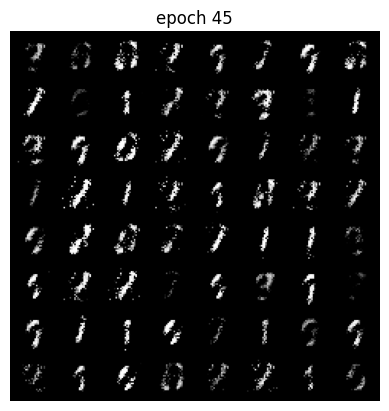

Epoch 45 of 100
Generator loss: 2.33354378, Discriminator loss: 0.61211860


118it [00:15,  7.63it/s]                         


Epoch 46 of 100
Generator loss: 2.50993085, Discriminator loss: 0.68264514


118it [00:15,  7.48it/s]                         


Epoch 47 of 100
Generator loss: 2.03373957, Discriminator loss: 0.71524262


118it [00:15,  7.51it/s]                         


Epoch 48 of 100
Generator loss: 2.50423384, Discriminator loss: 0.49823651


118it [00:15,  7.57it/s]                         


Epoch 49 of 100
Generator loss: 2.52487659, Discriminator loss: 0.63611490


118it [00:15,  7.65it/s]                         


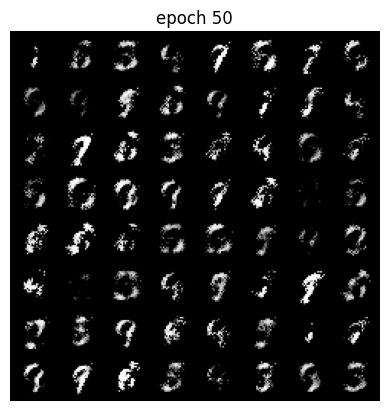

Epoch 50 of 100
Generator loss: 2.53698444, Discriminator loss: 0.62360471


118it [00:15,  7.63it/s]                         


Epoch 51 of 100
Generator loss: 2.56981230, Discriminator loss: 0.60432261


118it [00:15,  7.52it/s]                         


Epoch 52 of 100
Generator loss: 2.20937872, Discriminator loss: 0.71512002


118it [00:15,  7.67it/s]                         


Epoch 53 of 100
Generator loss: 2.46865702, Discriminator loss: 0.59175098


118it [00:15,  7.62it/s]                         


Epoch 54 of 100
Generator loss: 2.25476003, Discriminator loss: 0.72854286


118it [00:15,  7.69it/s]                         


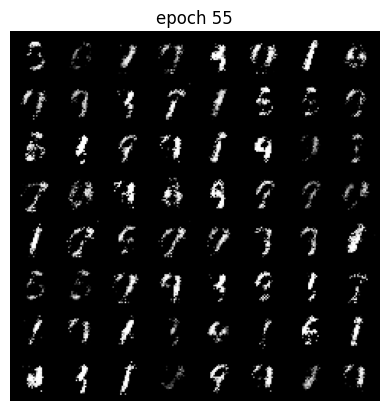

Epoch 55 of 100
Generator loss: 2.29068398, Discriminator loss: 0.62863618


118it [00:16,  7.31it/s]                         


Epoch 56 of 100
Generator loss: 2.58075762, Discriminator loss: 0.56125987


118it [00:16,  7.07it/s]                         


Epoch 57 of 100
Generator loss: 2.35383415, Discriminator loss: 0.66464245


118it [00:16,  7.26it/s]                         


Epoch 58 of 100
Generator loss: 2.01655936, Discriminator loss: 0.74368495


118it [00:15,  7.47it/s]                         


Epoch 59 of 100
Generator loss: 2.27936959, Discriminator loss: 0.70674419


118it [00:15,  7.67it/s]                         


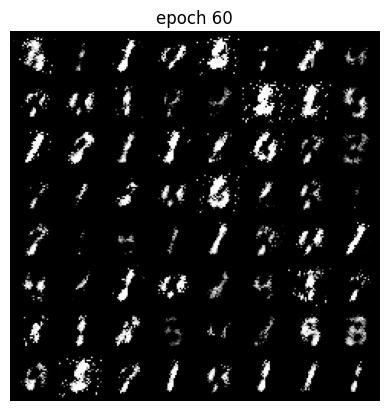

Epoch 60 of 100
Generator loss: 2.38178849, Discriminator loss: 0.59981084


118it [00:15,  7.66it/s]                         


Epoch 61 of 100
Generator loss: 2.48124790, Discriminator loss: 0.62264991


118it [00:15,  7.70it/s]                         


Epoch 62 of 100
Generator loss: 2.53226256, Discriminator loss: 0.62376702


118it [00:15,  7.61it/s]                         


Epoch 63 of 100
Generator loss: 2.52796888, Discriminator loss: 0.53026801


118it [00:15,  7.55it/s]                         


Epoch 64 of 100
Generator loss: 2.41596413, Discriminator loss: 0.60879290


118it [00:15,  7.55it/s]                         


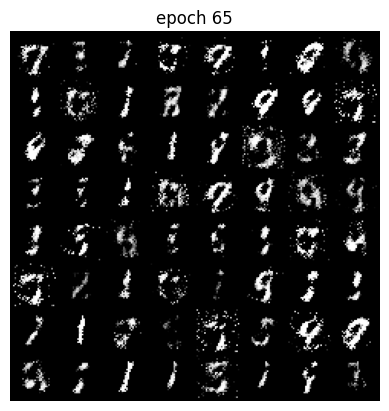

Epoch 65 of 100
Generator loss: 2.40727687, Discriminator loss: 0.60202247


118it [00:16,  7.29it/s]                         


Epoch 66 of 100
Generator loss: 2.57820296, Discriminator loss: 0.57869971


118it [00:15,  7.42it/s]                         


Epoch 67 of 100
Generator loss: 2.57349491, Discriminator loss: 0.59026104


118it [00:15,  7.61it/s]                         


Epoch 68 of 100
Generator loss: 2.38897371, Discriminator loss: 0.61328673


118it [00:15,  7.51it/s]                         


Epoch 69 of 100
Generator loss: 2.41907334, Discriminator loss: 0.61843687


118it [00:15,  7.54it/s]                         


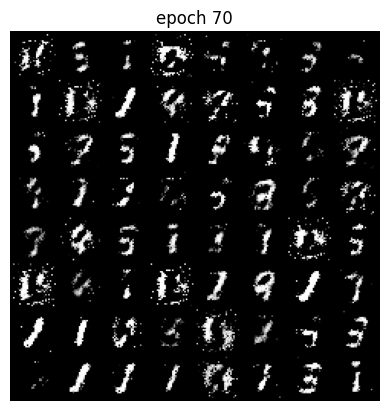

Epoch 70 of 100
Generator loss: 2.30662727, Discriminator loss: 0.69135606


118it [00:15,  7.58it/s]                         


Epoch 71 of 100
Generator loss: 2.12479639, Discriminator loss: 0.72881961


118it [00:15,  7.49it/s]                         


Epoch 72 of 100
Generator loss: 2.22935271, Discriminator loss: 0.68307930


118it [00:15,  7.51it/s]                         


Epoch 73 of 100
Generator loss: 2.40398645, Discriminator loss: 0.63506949


118it [00:15,  7.45it/s]                         


Epoch 74 of 100
Generator loss: 2.26820922, Discriminator loss: 0.71871442


118it [00:16,  7.24it/s]                         


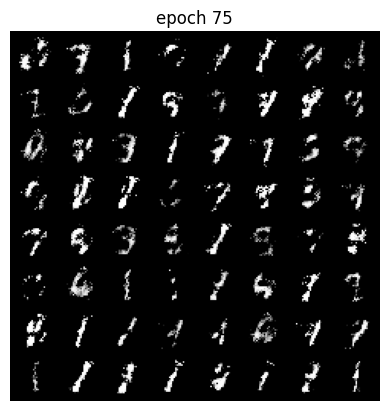

Epoch 75 of 100
Generator loss: 2.01945782, Discriminator loss: 0.74574804


118it [00:15,  7.54it/s]                         


Epoch 76 of 100
Generator loss: 2.13060045, Discriminator loss: 0.74472106


118it [00:15,  7.54it/s]                         


Epoch 77 of 100
Generator loss: 2.33294082, Discriminator loss: 0.68852776


118it [00:15,  7.59it/s]                         


Epoch 78 of 100
Generator loss: 2.22432303, Discriminator loss: 0.70157564


118it [00:15,  7.43it/s]                         


Epoch 79 of 100
Generator loss: 2.22366023, Discriminator loss: 0.68037558


118it [00:15,  7.50it/s]                         


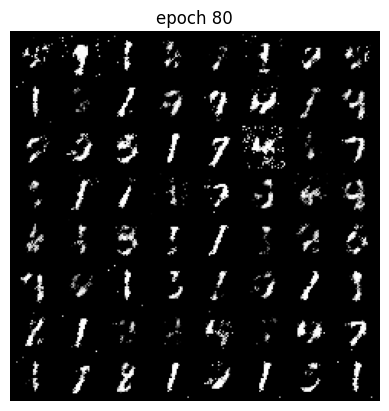

Epoch 80 of 100
Generator loss: 2.20302987, Discriminator loss: 0.70817691


118it [00:15,  7.44it/s]                         


Epoch 81 of 100
Generator loss: 2.13871408, Discriminator loss: 0.76313239


118it [00:15,  7.41it/s]                         


Epoch 82 of 100
Generator loss: 2.09563446, Discriminator loss: 0.74557078


118it [00:16,  7.04it/s]                         


Epoch 83 of 100
Generator loss: 2.21801019, Discriminator loss: 0.69856995


118it [00:16,  7.01it/s]                         


Epoch 84 of 100
Generator loss: 2.09535551, Discriminator loss: 0.74835312


118it [00:16,  7.23it/s]                         


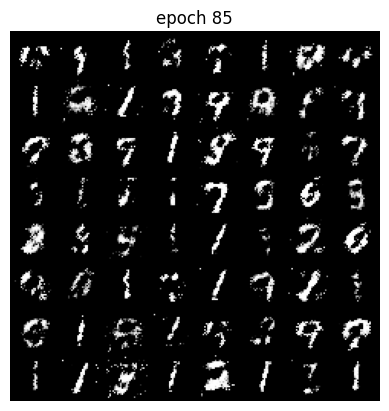

Epoch 85 of 100
Generator loss: 2.32516193, Discriminator loss: 0.68504524


118it [00:15,  7.41it/s]                         


Epoch 86 of 100
Generator loss: 2.36878872, Discriminator loss: 0.69534862


118it [00:15,  7.42it/s]                         


Epoch 87 of 100
Generator loss: 2.23478556, Discriminator loss: 0.67592764


118it [00:16,  7.30it/s]                         


Epoch 88 of 100
Generator loss: 2.36453986, Discriminator loss: 0.66632789


118it [00:15,  7.45it/s]                         


Epoch 89 of 100
Generator loss: 2.27325034, Discriminator loss: 0.70658010


118it [00:16,  7.34it/s]                         


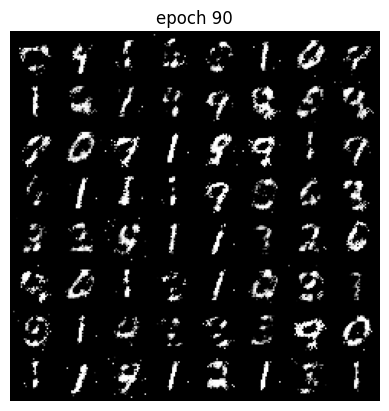

Epoch 90 of 100
Generator loss: 2.29108000, Discriminator loss: 0.70696205


118it [00:16,  7.17it/s]                         


Epoch 91 of 100
Generator loss: 2.31632996, Discriminator loss: 0.63900781


118it [00:16,  7.07it/s]                         


Epoch 92 of 100
Generator loss: 2.42058659, Discriminator loss: 0.61721635


118it [00:15,  7.39it/s]                         


Epoch 93 of 100
Generator loss: 2.30874395, Discriminator loss: 0.68161207


118it [00:16,  7.27it/s]                         


Epoch 94 of 100
Generator loss: 2.27572751, Discriminator loss: 0.72610116


118it [00:15,  7.39it/s]                         


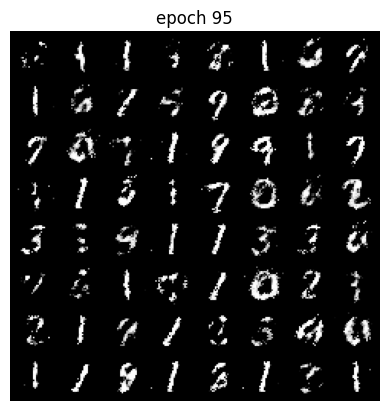

Epoch 95 of 100
Generator loss: 2.11116385, Discriminator loss: 0.73035640


118it [00:16,  7.36it/s]                         


Epoch 96 of 100
Generator loss: 2.02079797, Discriminator loss: 0.77364802


118it [00:16,  7.29it/s]                         


Epoch 97 of 100
Generator loss: 1.99004686, Discriminator loss: 0.77976948


118it [00:16,  7.17it/s]                         


Epoch 98 of 100
Generator loss: 2.07005930, Discriminator loss: 0.75903368


118it [00:16,  7.06it/s]                         


Epoch 99 of 100
Generator loss: 2.01480055, Discriminator loss: 0.77083480


118it [00:16,  7.21it/s]                         


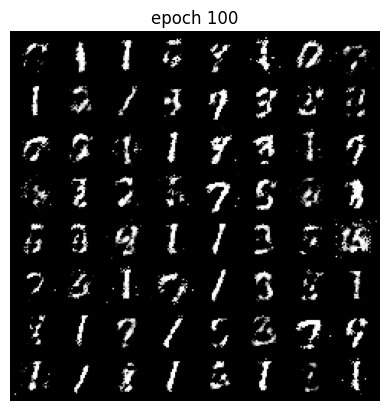

Epoch 100 of 100
Generator loss: 2.05513549, Discriminator loss: 0.76379639


In [14]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    return criterion(output,true_label)


    ######################################

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    loss = criterion(output, true_label)
    return loss

    ######################################


for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
      ############ YOUR CODE HERE ##########

      ##Training Discriminator
      real_data, _ = data
      real_data = real_data.cuda()

      batch_size = real_data.shape[0]
      optim_d.zero_grad()
      ##Train on Real data
      predictions_real = discriminator(real_data).view(-1)

      target_real = label_real(predictions_real.shape[0]).squeeze(1)
      disc_loss_real = discriminator_loss(predictions_real, target_real)
      disc_loss_real.backward()

      rand_noise = create_noise(batch_size, nz)
      fake_images = generator(rand_noise)
      predictions_fake = discriminator(fake_images.detach()).view(-1)

      target_fake = label_fake(predictions_fake.shape[0]).squeeze(1)
      disc_loss_fake = discriminator_loss(predictions_fake, target_fake)
      disc_loss_fake.backward()
      optim_d.step()


      loss_d += disc_loss_real + disc_loss_fake

      ##Generator Training
      optim_g.zero_grad()
      rand_noise = create_noise(batch_size, nz)
      fake_images = generator(rand_noise)
      predictions_disc = discriminator(fake_images).view(-1)

      target_real_generator = label_real(predictions_disc.shape[0]).squeeze(1)
      loss_generator = generator_loss(predictions_disc, target_real_generator)

      loss_generator.backward()

      loss_g += loss_generator

      optim_g.step()



        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

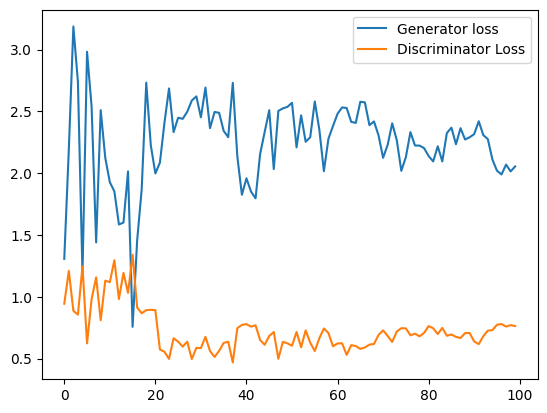

In [17]:
# # plot and save the generator and discriminator loss

numpy_list_d = [tensor.cpu().detach().numpy() for tensor in losses_d]
numpy_list_g = [tensor.cpu().detach().numpy() for tensor in losses_g]
plt.figure()
plt.plot(numpy_list_g, label='Generator loss')
plt.plot(numpy_list_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')

In [18]:
# # plot and save the generator and discriminator loss
# plt.figure()
# plt.plot(losses_g, label='Generator loss')
# plt.plot(losses_d, label='Discriminator Loss')
# plt.legend()
# plt.savefig('outputs/loss.png')

In [19]:
# import shutil

# # Define the path to the folder you want to zip
# folder_path = '/content/outputs'  # Update this with your folder path

# # Define the name for the zip file
# zip_filename = '/content/outputs.zip'  # Update this with your desired zip file name

# # Zip the folder
# shutil.make_archive(zip_filename.split('.zip')[0], 'zip', folder_path)
